In [32]:
import pandas as pd # pandas is used to load and manipulate data and for One-Hot Encoding
import numpy as np # numpy is used to calculate the mean and standard deviation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation and hyperparameter tuning
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA # to perform PCA to plot the data
import seaborn as sns

In [33]:
df = pd.read_csv('processed.cleveland.data', header=None)

In [34]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [35]:
df.columns = ['age',
              'sex',
              'cp',
              'restbp',
              'chol',
              'fbs',
              'restecg',
              'thalach',
              'exang',
              'oldpeak',
              'slope',
              'ca',
              'thal',
              'hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


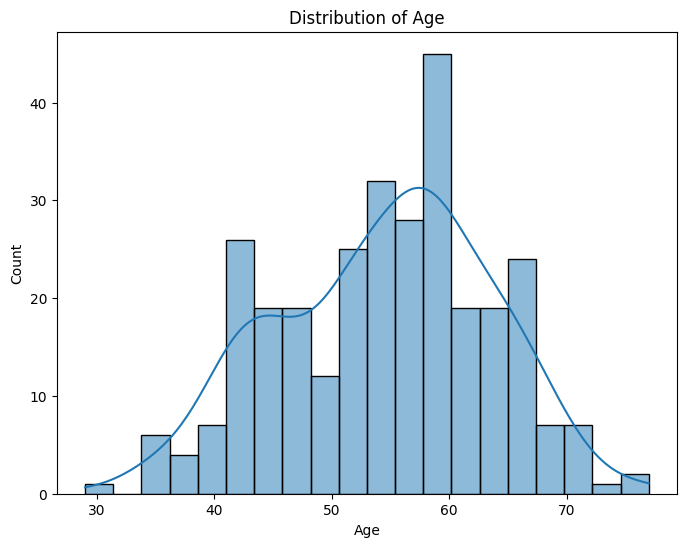

In [36]:
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [37]:
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

In [38]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [39]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

In [40]:
len(df.loc[(df['ca'] == '?') | (df['thal'] == '?')])

6

Since only 6 rows have missing values, let's look at them.

In [41]:
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Now let's count the number of rows in the full dataset.

In [42]:
len(df)

303

So 6 of the **303** rows, or **2%**, contain missing values. Since **303 - 6 = 297**, and **297** is plenty of data to build a support vector machine, we will remove the rows with missing values, rather than try to impute their values. We do this by selecting all of the rows that do not contain question marks in either the **ca** or **thal** columns:

In [43]:
df_no_missing = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]

In [44]:
len(df_no_missing)

297

In [45]:
X = df_no_missing.drop('hd', axis = 1).copy()

In [46]:
y = df_no_missing['hd'].copy()

In [47]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

In [48]:
X['cp'].unique()

array([1., 4., 3., 2.])

In [49]:
X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


Now, one last thing before we build a Support Vector Machine.  `y` doesn't just contain **0**s and **1**s. Instead, it has **5** different levels of heart disease. **0 =** no heart disease and **1-4** are various degrees of heart disease. We can see this with `unique()`:

In [50]:
y.unique()

array([0, 2, 1, 3, 4])

In [51]:
y_not_zero_idx = y > 0
y[y_not_zero_idx] = 1
y.unique()

array([0, 1])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

----

In [54]:
y_pred = clf_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        42
           1       0.85      0.85      0.85        33

    accuracy                           0.87        75
   macro avg       0.86      0.86      0.86        75
weighted avg       0.87      0.87      0.87        75

